<a href="https://colab.research.google.com/github/therealcyberlord/tensorflow_keras_color_images_denoiser/blob/master/better_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive, files
from __future__ import absolute_import, unicode_literals, print_function
import matplotlib.pyplot as plt 
import pickle 
import cv2 
import numpy as np 
from sklearn.model_selection import train_test_split

Loads the pickle that stores the pictures of dogs

In [0]:
drive.mount('/content/gdrive')
data = pickle.load(open('/content/gdrive/My Drive/Data/Dogs and Cats/denoise_training.pickle', 'rb'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

Load a picture

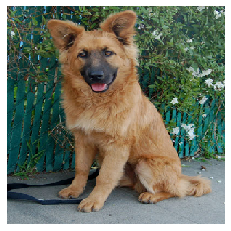

In [0]:
plot_rgb_img(data[20])

Here are some ways to add noise to images

In [0]:
def add_gaussian_blur(data):
  dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
  return dst

In [0]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise

In [0]:
# adds salt and pepper noise 
def add_salt_pepper_noise(data, p=0.05):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output

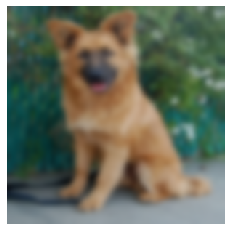

In [0]:
plot_rgb_img(add_gaussian_blur(data[20]))

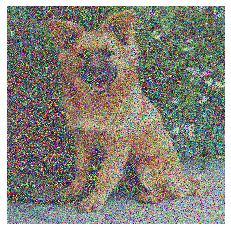

In [0]:
plot_rgb_img(add_gaussian_noise(data[20]))

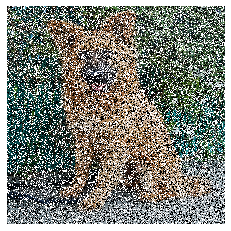

In [0]:
plot_rgb_img(add_salt_pepper_noise(data[20], p=0.5))

Apply it to an entire dataset rather than one image 

In [0]:
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)

In [0]:
def add_gaussian_blur_to_dataset(data):
  count = 0 
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

I am using a smaller training set to reserve memory, use more pictures if you have a lot of RAM. 

In [0]:
train_data = data[:3000]
test_data = data[3000:4000]
# gaussian_train_data = add_gaussian_to_dataset(train_data)
# gaussian_test_data = add_gaussian_to_dataset(test_data)

In [0]:
gaussian_train_data = add_gaussian_blur_to_dataset(train_data)
gaussian_test_data = add_gaussian_blur_to_dataset(test_data)

Scale the data between 0 and 1

In [0]:
train_data = train_data / 255.0
test_data = test_data / 255.0
gaussian_train_data = gaussian_train_data / 255.0 
gaussian_test_data = gaussian_test_data / 255.0 

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Construct the autoencoder model

In [0]:
def create_model():
  x = Input(shape=(300, 300, 3)) 

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model

In [0]:
gaussian_auto_encoder = create_model()
gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_data, train_data, epochs=50, batch_size=32, callbacks=[gaussian_early_stop])

















Epoch 1/50
3000/3000 [==============================] - 21s 7ms/step - loss: 0.0141
Epoch 2/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0083
Epoch 3/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0073
Epoch 4/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0069
Epoch 5/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0070
Epoch 6/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0063
Epoch 7/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0062
Epoch 8/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0062
Epoch 9/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0063
Epoch 10/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0059
Epoch 11/50
3000/3000 [==============================] - 16s 5ms/step - loss: 0.0058
Epoch 12/50
3000/3000 [==============================] - 1

Plot the training loss

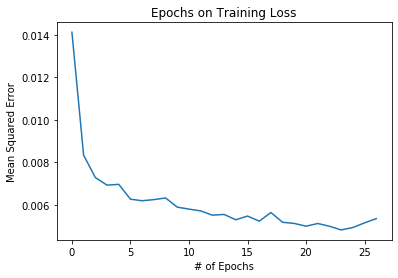

In [0]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [0]:
gaussian_auto_encoder.save('gaussian_blur.model')
files.download('gaussian_blur.model')

Evaluate the model on the test set

In [0]:
result = gaussian_auto_encoder.predict(gaussian_test_data)
gaussian_auto_encoder.evaluate(test_data, gaussian_test_data)

1000/1000 [==============================] - 4s 4ms/step


0.053349989891052246

Compare the images

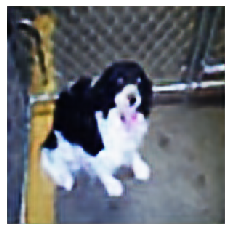

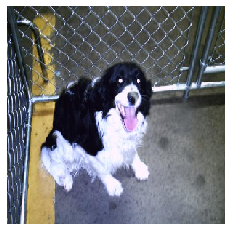

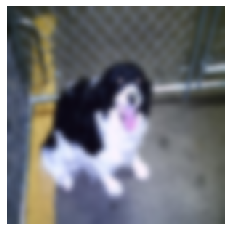

In [0]:
plot_rgb_img(result[15])
plot_rgb_img(data[3015])
plot_rgb_img(add_gaussian_blur(data[3015]))